In [32]:
#%matplotlib notebook
import math                              # 数学ライブラリ
import numpy as np                       # 数値計算用の配列
import numpy.linalg as LA                # 行列計算ライブラリ
import matplotlib.pyplot as plt          # 可視化ライブラリ
from matplotlib.pyplot import figure

## Runge-Kutta 4th order (removed t for simplicity)

f = 8; dt = 0.005;  n = 40; 

def x_a_dot(x_a):
    return (np.roll(x_a,-1)-np.roll(x_a,2))*np.roll(x_a,1) - x_a +f 

def lorenz96_step(x_a):     # RK 4th order. By default, no need to provide time info (because there is no t in the right hand side)
    k1 = x_a_dot(x_a)
    k2 = x_a_dot((x_a + 0.5*k1*dt))
    k3 = x_a_dot((x_a + 0.5*k2*dt))
    k4 = x_a_dot((x_a + k3*dt))
    return np.array(x_a+ (dt*(k1 + 2*k2 + 2*k3 + k4) / 6))

In [33]:
# model to update x_a and p_a
def lorenz96_forecast(x_a, p_a):
    x_f = lorenz96_step(x_a)  
    # update error matrix by linear model
    eps = 1.0e-8
    m = np.zeros_like(p_a)
    for ii in range(len(x_a)):
        x_a_eps = np.zeros_like(x_a)
        x_a_eps[ii] += eps
        m[ii] = (lorenz96_step(x_a + x_a_eps) - lorenz96_step(x_a))/eps
    m = m.T
    # update background error covariance matrix
    p_f = m @ p_a @ (m.T)
    #print(np.linalg.norm(m))
    return x_f, p_f, m

# kalman filter: forecast + observation --> analysis
def KalmanFilter(x_f,p_f,y,R,H):
    kalman_gain = p_f @ (H.T) @ LA.inv(H @ p_f @ (H.T) + R)
    x_a = x_f + kalman_gain @ (y - H @ x_f)
    p_a = (np.identity(n) - kalman_gain @ H) @ p_f
    return x_a,p_a

Text(0, 0.5, 'time step')

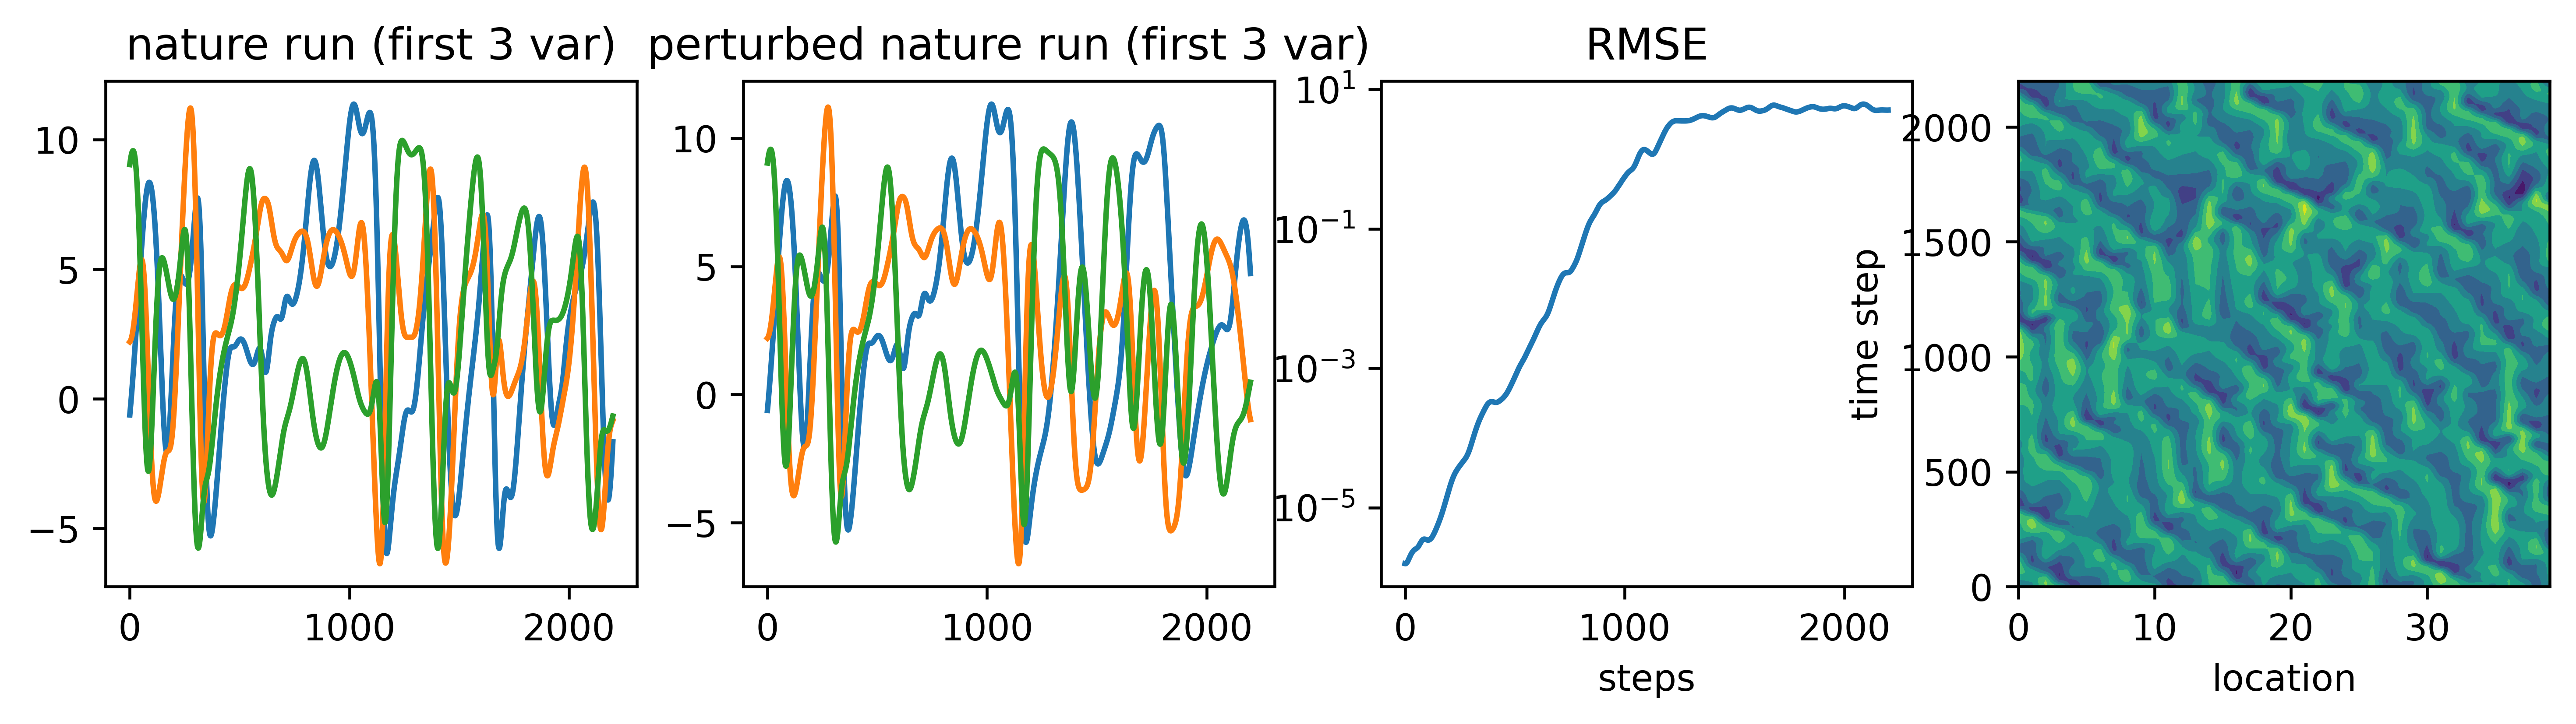

In [37]:
# Create observations: add perturbation onto nature run

# Step 1: create nature run (virtual truth)
n_steps = 2200
nature = []
#x0_ = np.array(np.random.randn(n), dtype=np.float64)
#x0_ = np.array([0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9], dtype=np.float64)
x0_ = np.array([-7.14515282e-01,  2.18901382e+00,  8.96410450e+00,  6.17594705e+00,       -2.72968500e+00, -2.98115211e+00, -3.09979742e-03,  4.60571996e+00,        3.59366294e+00,  3.81990545e+00,  4.77793655e+00, -2.76459717e+00,       -3.51057287e+00,  1.83922796e+00,  4.87497716e+00,  7.33165469e+00,        6.17024328e+00, -1.27681135e+00,  2.55693455e+00, -1.25531837e+00,        7.21313753e-01,  1.93019534e+00,  6.90871427e+00,  2.44531533e+00,       -2.50672372e+00,  3.22264341e+00,  7.52272313e+00, -4.96987962e-01,       -3.47440106e+00,  2.66745601e-01,  3.50690401e+00,  7.27108171e+00,        6.25627245e+00,  5.70534082e+00,  4.39655844e+00,  2.14429329e+00,        6.01607938e+00,  4.96662391e+00, -1.73948248e+00,  2.41560143e+00])
x0 = x0_
for _ in range(n_steps):
    x0 = lorenz96_step(x0)
    nature.append(x0)

nature = np.array(nature)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4); fig.dpi=600; fig.set_size_inches(12, 2.5)
ax1.plot(nature[:,0:3]); ax1.set_title('nature run (first 3 var)')

# Step 2: how does error grow?
nature_perturbed = []
x0 = x0_
x0[30] += 0.00001
for _ in range(n_steps):
    x0 = lorenz96_step(x0)
    nature_perturbed.append(x0)
    
nature_perturbed = np.array(nature_perturbed)
ax2.plot(nature_perturbed[:,0:3]);ax2.set_title('perturbed nature run (first 3 var)')

diff = nature - nature_perturbed; rmse = np.sqrt(np.sum(diff*diff,1)/n)
ax3.plot(rmse); ax3.set_yscale('log'); ax3.set_xlabel('steps'); ax3.set_title('RMSE');#ax3.set_xlim([0, 3000]);

# lorenz96 has no jump because of large n? 
# lorenz63 has jump because of the non-uniform error growth rate?
# note: error doubling time in Lorenz63 is around 75 steps; so DA interval should be around 75/8 ~ 10 steps
ax4.contourf(nature[0:(40 * 100), :])
ax4.set_xlabel('location')
ax4.set_ylabel('time step')
#ax4.set_colorbar()

#10^-4.  -->  1
#within 1500 steps

Text(0.5, 0.92, 'observation')

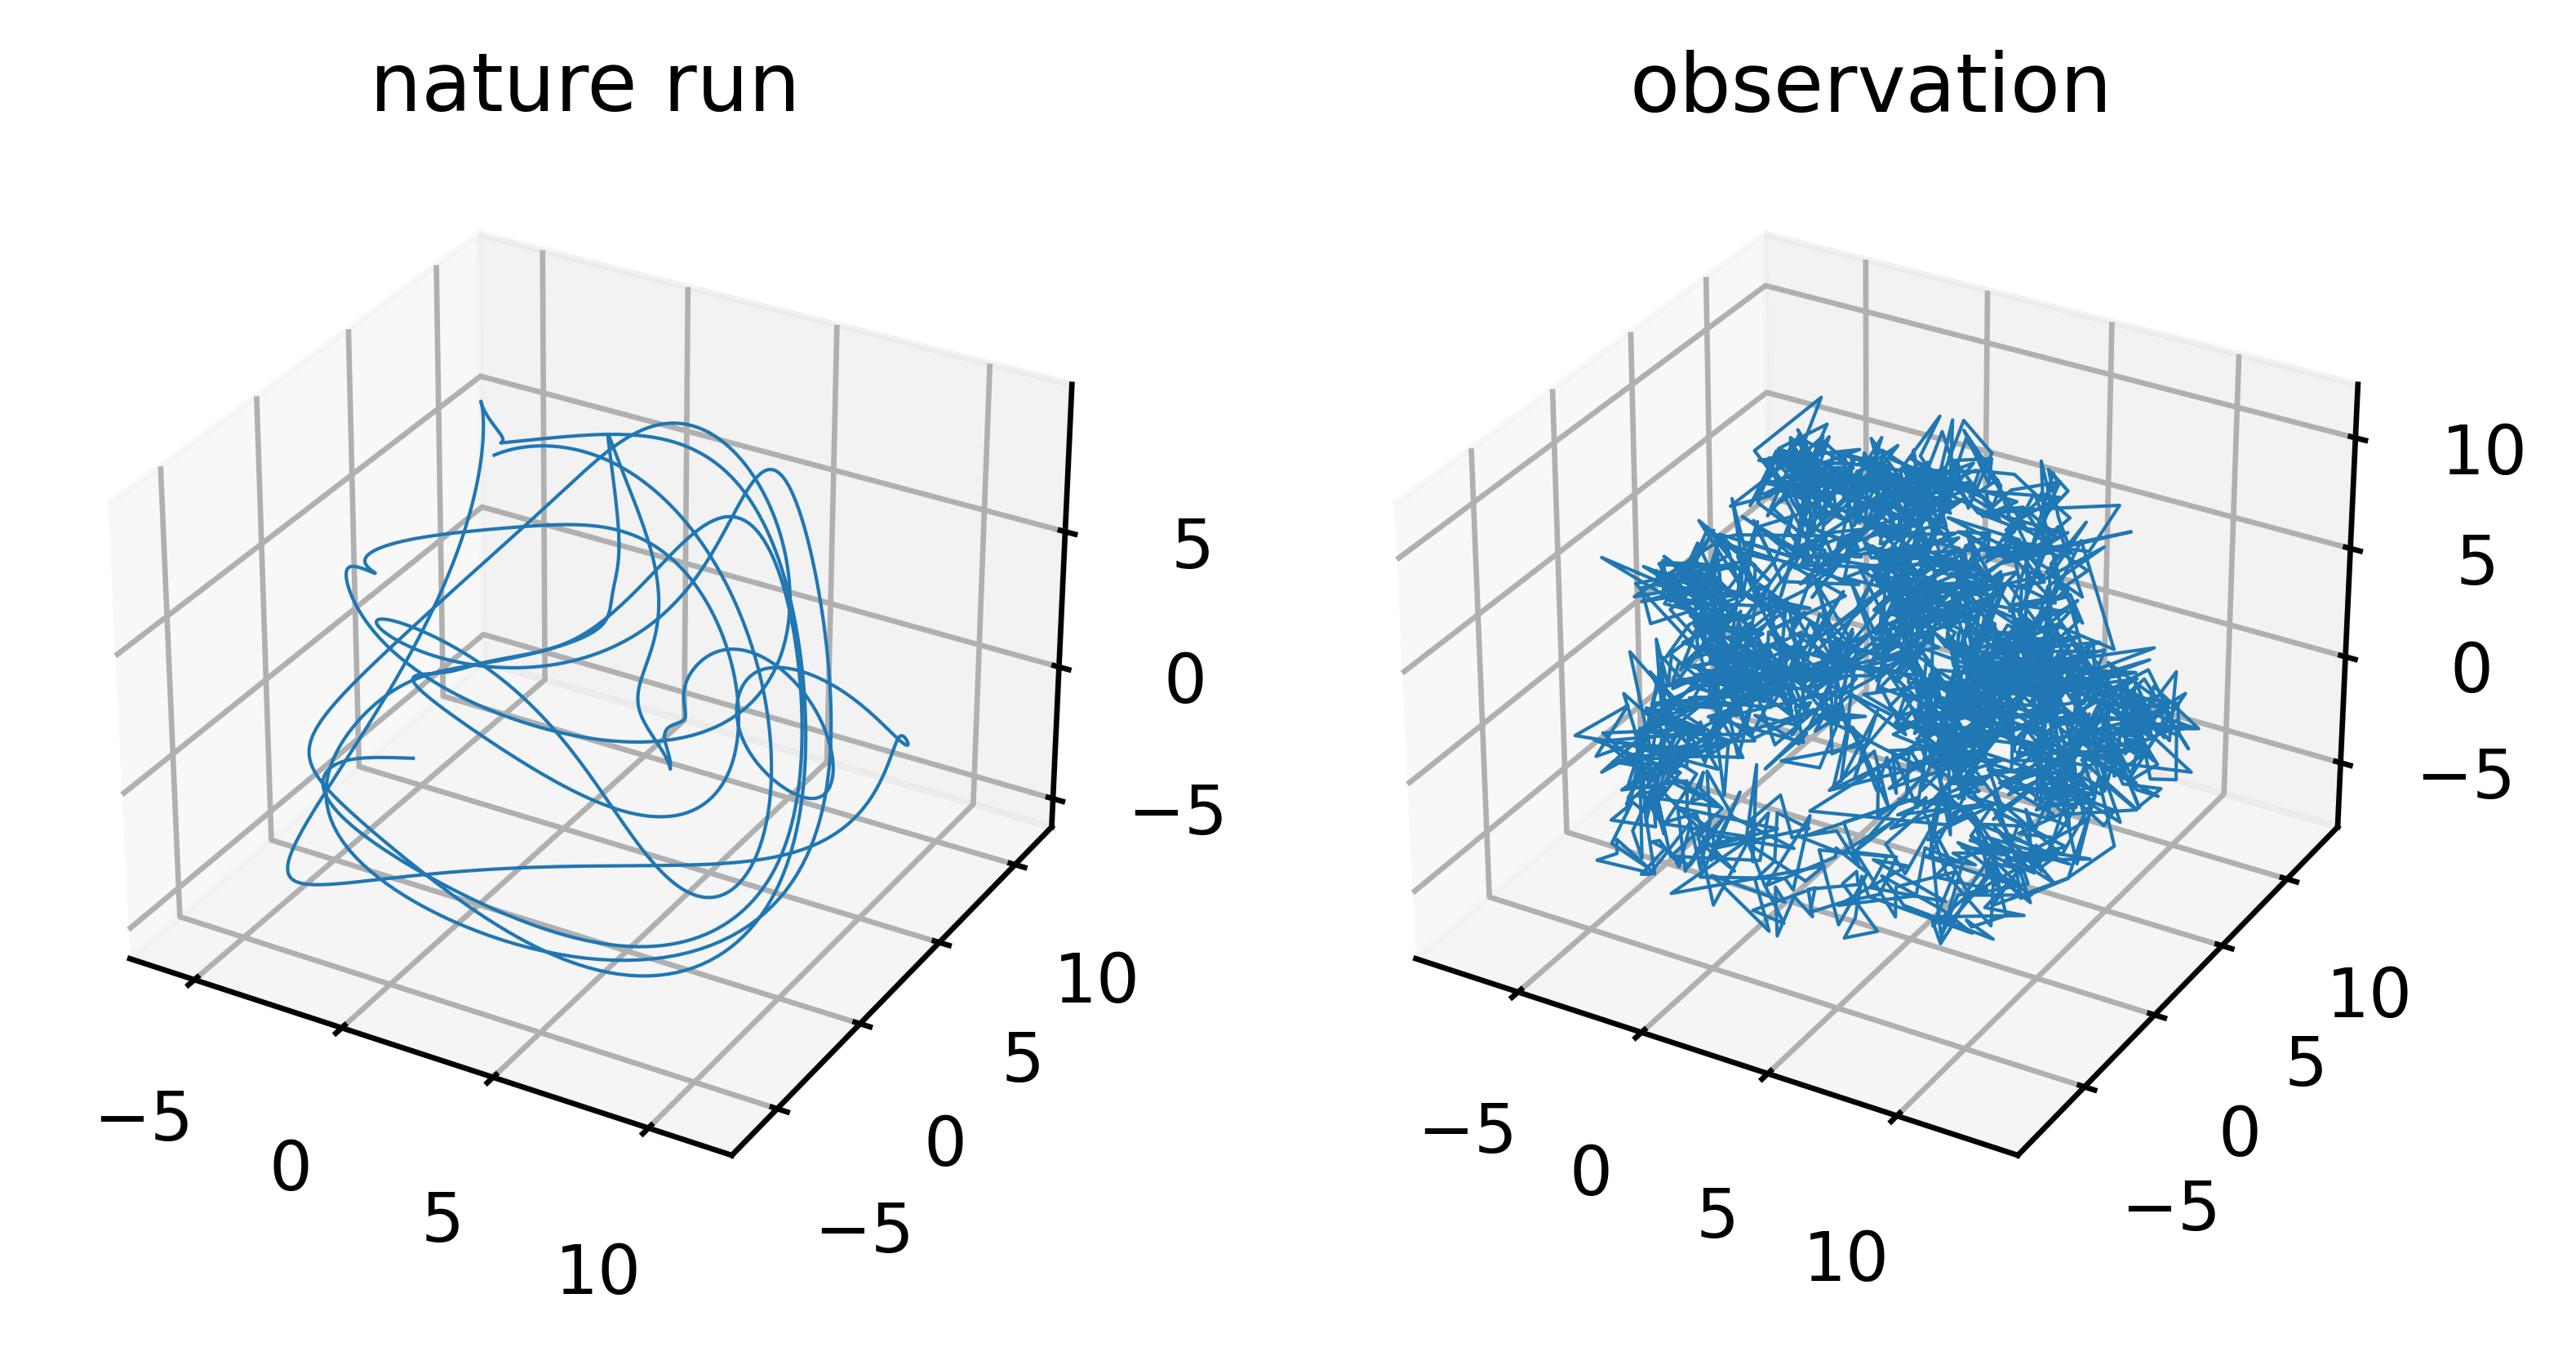

In [38]:
# Step 3: create observations: add perturbation to nature run

obs_err_std = np.sqrt(1);   obs = nature + np.random.randn(nature.shape[0], nature.shape[1]) * obs_err_std
#plt.plot(nature)
#plt.plot(obs)
#diff = nature-obs
#fig, ax = plt.subplots();fig.dpi=600;ax.set_aspect(10); ax.set_xlim([0, 1000])
#ax.plot(diff[:,1],linewidth=0.5)

# 3D plot 
fig = plt.figure(figsize=plt.figaspect(0.5)); fig.dpi=600; #fig.set_size_inches(12, 2.5)
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.plot(nature[:,0], nature[:,1], nature[:,2], lw=0.5)
ax1.set_title('nature run')

ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.plot(obs[:,0], obs[:,1], obs[:,2], lw=0.5)
ax2.set_title('observation')

#ax3 = fig.add_subplot(1, 3, 3, projection='3d')
#ax3.plot(obs[::10,0], obs[::10,1], obs[::10,2], lw=0.5)
#ax3.set_title('observation (every 10th)')


# Step 4: discard the spin-up period
#n_spinup = 40*30  # 1 year real-world time as spin-up time
#nature = nature[n_spinup:]
#obs = obs[n_spinup:]
#n_steps = n_steps-n_spinup
#print("nature length",len(nature),"; n_steps =",n_steps)

In [42]:
# adjust the observation error 
import random
obs_err_std = np.sqrt(1);   
obs = nature + np.random.randn(nature.shape[0], nature.shape[1]) * obs_err_std


# run the DA process
R = np.identity(n) * obs_err_std**2
H = np.identity(n)
p_a = np.identity(n)*10  # 10 is the size of saturated error in Lorenz63
x_a = x0_  # random number as the initial state; ideally we should use spin-up
analysis_intv = 10 
x_a_history = []
p_a_norm_history = []
m_norm_history = []
m_eigen_history = []


# how to introduce random observation of partial observation?
# 1 constant interval 2 random location, constant with time 3 random location, changing with time
random_type = 1
num_obs = 10

if random_type == 1:
    obs_idx = range(0,n,int(40/num_obs))  # constant interval
    H = H[obs_idx,:]; R = np.identity(len(obs_idx)) * obs_err_std**2
elif random_type == 2:
    obs_idx = random.sample(range(40), k=num_obs);obs_idx.sort() # randomly choosing
    H = H[obs_idx,:]; R = np.identity(len(obs_idx)) * obs_err_std**2

    
for ii in range(n_steps // analysis_intv):
    if random_type==3:
        obs_idx = random.sample(range(40), k=num_obs);obs_idx.sort() # randomly choosing
        H = np.identity(n); H = H[obs_idx,:]; R = np.identity(len(obs_idx)) * obs_err_std**2


    for jj in range(analysis_intv):
        p_a_norm_history.append(np.linalg.norm(p_a))
        x_f, p_f,m = lorenz96_forecast(x_a, p_a)
        x_a, p_a = x_f, p_f
        x_a_history.append(x_a)
        m_norm_history.append(np.linalg.norm(m))
        eig_m = np.linalg.eigvals(m); m_eigen_history.append(max(eig_m.real))
        
    y = obs[(ii+1)*analysis_intv-1,obs_idx]
    x_a,p_a = KalmanFilter(x_f,p_f,y,R,H)
    p_a *= 1.7-0.0 # inflation or not
    
    if ii % 100 == 0:
      print("analysis ", ii)
    else:
      print(".", end="")
print("Done")
x_a_history = np.array(x_a_history)



analysis  0
...................................................................................................analysis  100
...................................................................................................analysis  200
...................Done


5.063783588655244


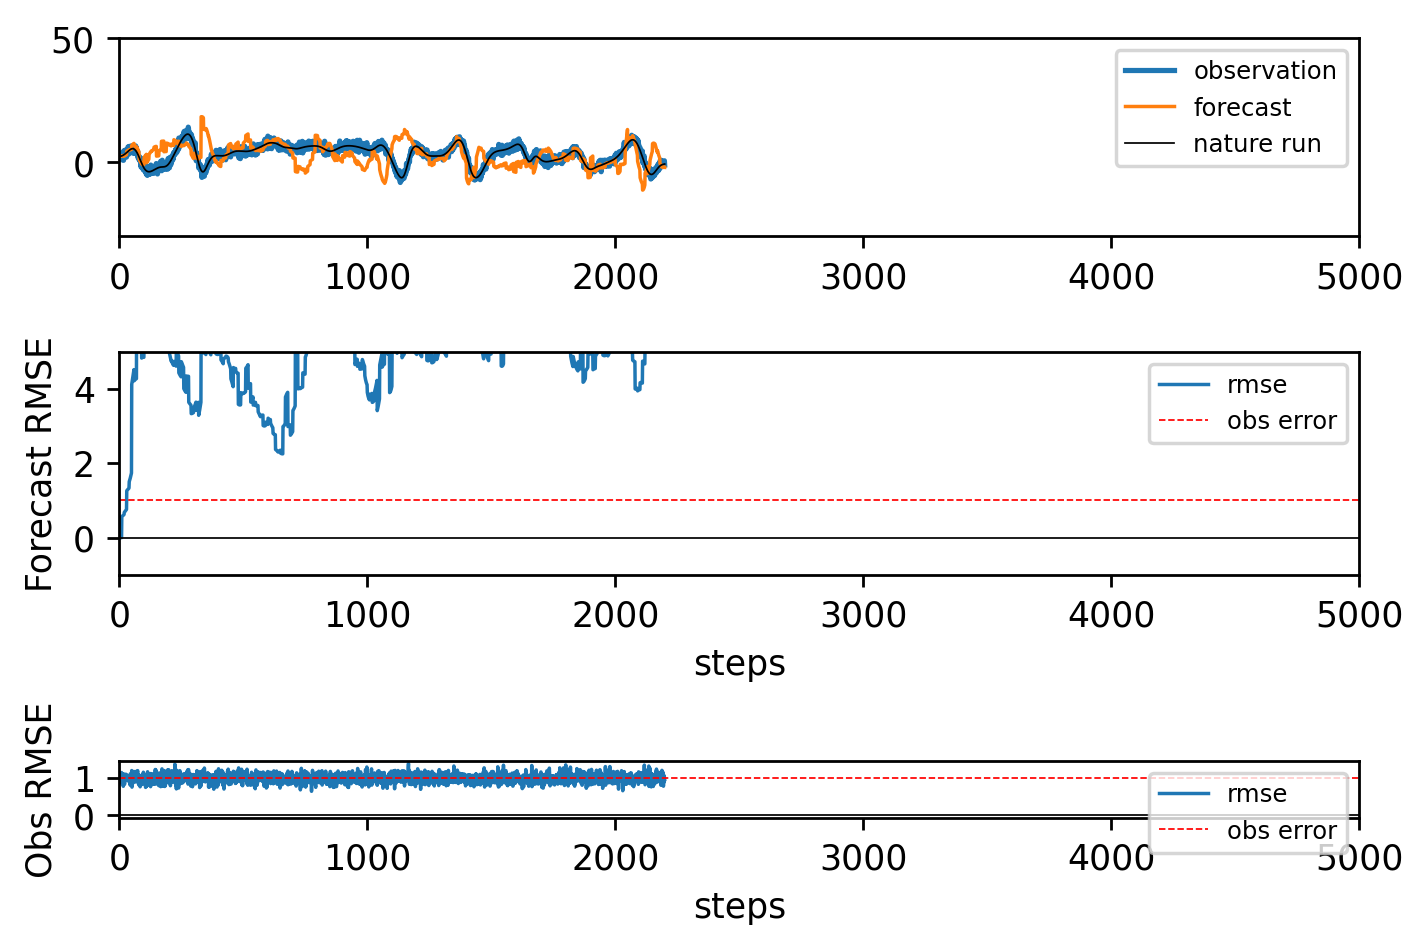

In [43]:
# plot the first variable 
fig, (ax1, ax2, ax3) = plt.subplots(3, 1);fig.dpi=250
ax1.plot(obs[:,1],label = 'observation')
ax1.plot(x_a_history[:,1],linewidth=1, label = 'forecast' )
ax1.plot(nature[:,1],label = 'nature run', color='black',linewidth=0.5)
ax1.set_aspect(10); ax1.set_xlim([0, 5000]); ax1.set_ylim([-30, 50])
ax1.legend(loc = 'upper right',fontsize = 7)

# Forecast RMSE
diff = nature - x_a_history
rmse = np.sqrt(np.sum(diff*diff,1)/n)
ax2.set_aspect(150); ax2.set_xlim([0, 5000]);ax2.set_ylim([-1, 5])
ax2.set_xlabel('steps'); ax2.set_ylabel('Forecast RMSE')

ax2.plot(rmse,linewidth=1)
ax2.axhline(y=obs_err_std, color='r', linestyle='--',linewidth=0.5)
ax2.legend(['rmse','obs error'],loc = 'upper right',fontsize = 7)
ax2.axhline(y=0, color='black', linestyle='-',linewidth=0.5)

print(np.mean(rmse[300:5000]))


# Obs RMSE
diff = nature - obs
rmse = np.sqrt(np.sum(diff*diff,1)/n)
ax3.set_aspect(150); ax3.set_xlim([0, 5000]);#ax3.set_ylim([-1, 5])
ax3.set_xlabel('steps'); ax3.set_ylabel('Obs RMSE')

ax3.plot(rmse,linewidth=1)
ax3.axhline(y=obs_err_std, color='r', linestyle='--',linewidth=0.5)
ax3.legend(['rmse','obs error'],loc = 'upper right',fontsize = 7)
ax3.axhline(y=0, color='black', linestyle='-',linewidth=0.5)